<a href="https://colab.research.google.com/github/CupOfDim/classic_ml_notebooks/blob/main/Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Интерпретация моделей и калибровка вероятностей

Тренировка на примере задачи классификации оттоковых клиентов

In [ ]:
!pip install eli5 -q
!pip install lime -q
!pip install shap -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import eli5, lime, shap

from catboost import CatBoostClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Загрузим данные

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/churn_clients.csv")

data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


Обрабатываем признаки:

* удаляем категориальные признаки с больше, чем двумя различными значениями.

* бинарные признаки перведим в числа: True/Yes -> 1, False/No -> 0

In [ ]:
cat_columns = data.select_dtypes(include=['object', 'category'])

lim = 2
col_drop = ['areacode']
for column in cat_columns:
    uniq = data[column].nunique()
    if uniq > lim:
        col_drop.append(column)

data.drop(columns=col_drop, inplace=True)
data=data.replace({True:1, False:0, 'Yes':1, 'No':0})
data

,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,128,0,1,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,0
1,107,0,1,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,0
2,137,0,0,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,0
3,84,1,0,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,0
4,75,1,0,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77.0,26.55,215.5,126.0,18.32,279.1,83.0,12.56,9.9,6.0,2.67,2,0
3329,68,0,0,0,231.1,57.0,39.29,153.4,55.0,13.04,191.3,123.0,8.61,9.6,4.0,2.59,3,0
3330,28,0,0,0,180.8,109.0,30.74,288.8,58.0,24.55,191.9,91.0,8.64,14.1,6.0,3.81,2,0
3331,184,1,0,0,213.8,105.0,36.35,159.6,84.0,13.57,139.2,137.0,6.26,5.0,10.0,1.35,2,0


In [ ]:
X = data.drop('churn', axis=1)
y = data['churn']

Разбиваем данные на тренировочную и тестовую части. Размер тестовой части = 25%, `random_state=42`.

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
Xtrain

,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls
367,45,0,0,0,78.2,127.0,13.29,253.4,108.0,21.54,255.0,100.0,11.48,18.0,3.0,4.86,1
3103,115,0,0,0,195.9,111.0,33.30,227.0,108.0,19.30,313.2,113.0,14.09,13.2,1.0,3.56,2
549,121,0,1,31,237.1,63.0,40.31,205.6,117.0,17.48,196.7,85.0,8.85,10.1,5.0,2.73,4
2531,180,0,0,0,143.3,134.0,24.36,180.5,113.0,15.34,184.2,87.0,8.29,10.1,4.0,2.73,1
2378,112,0,0,0,206.2,122.0,35.05,164.5,94.0,13.98,140.3,101.0,6.31,12.6,7.0,3.40,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,106,0,0,0,274.4,120.0,46.65,198.6,82.0,16.88,160.8,62.0,7.24,6.0,3.0,1.62,1
1130,122,0,0,0,35.1,62.0,5.97,180.8,89.0,15.37,251.6,58.0,11.32,12.7,2.0,3.43,1
1294,66,0,0,0,87.6,76.0,14.89,262.0,111.0,22.27,184.6,125.0,8.31,9.2,5.0,2.48,1
860,169,0,0,0,179.2,111.0,30.46,175.2,130.0,14.89,228.6,92.0,10.29,9.9,6.0,2.67,2


Обучаем CatBoostClassifier с гиперпараметрами по умолчанию и `random_state=42` на тренировочных данных.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier(random_state=42)
model.fit(Xtrain, ytrain)

Найдем чему равно значение ROC-AUC на тестовых данных.

In [ ]:
from sklearn.metrics import roc_auc_score

ypred = model.predict_proba(Xtest)

roc_auc = roc_auc_score(ytest, ypred[:,0])
roc_auc

0.06623413258110013

Гистограмма важности признаков (стандартная, посчитанная на основе Information Gain)

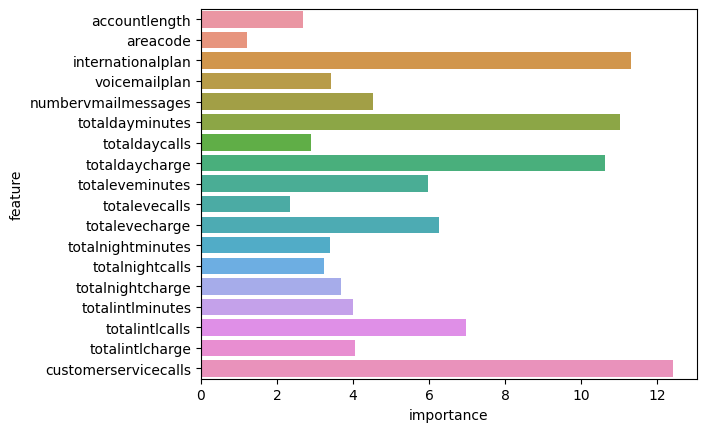

In [ ]:
feature_imp = pd.DataFrame({'feature':X.columns,
                            'importance':model.feature_importances_})
sns.barplot(data=feature_imp, x='importance', y='feature')
plt.show()

Находим важные признаки с помощью метеода Permutation Importancem и строим таблицу

In [ ]:
perm = eli5.sklearn.PermutationImportance(model, random_state=42).fit(Xtrain, ytrain)
eli5.show_weights(perm, feature_names=Xtrain.columns.tolist())

Weight,Feature
0.0577 ± 0.0058,customerservicecalls
0.0518 ± 0.0034,totaldayminutes
0.0511 ± 0.0022,internationalplan
0.0475 ± 0.0042,totaldaycharge
0.0246 ± 0.0039,totalintlcalls
0.0202 ± 0.0040,totalevecharge
0.0189 ± 0.0014,totaleveminutes
0.0146 ± 0.0035,numbervmailmessages
0.0126 ± 0.0015,voicemailplan
0.0122 ± 0.0032,totalintlcharge


Строим гистограмму shap values по тестовым данным

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


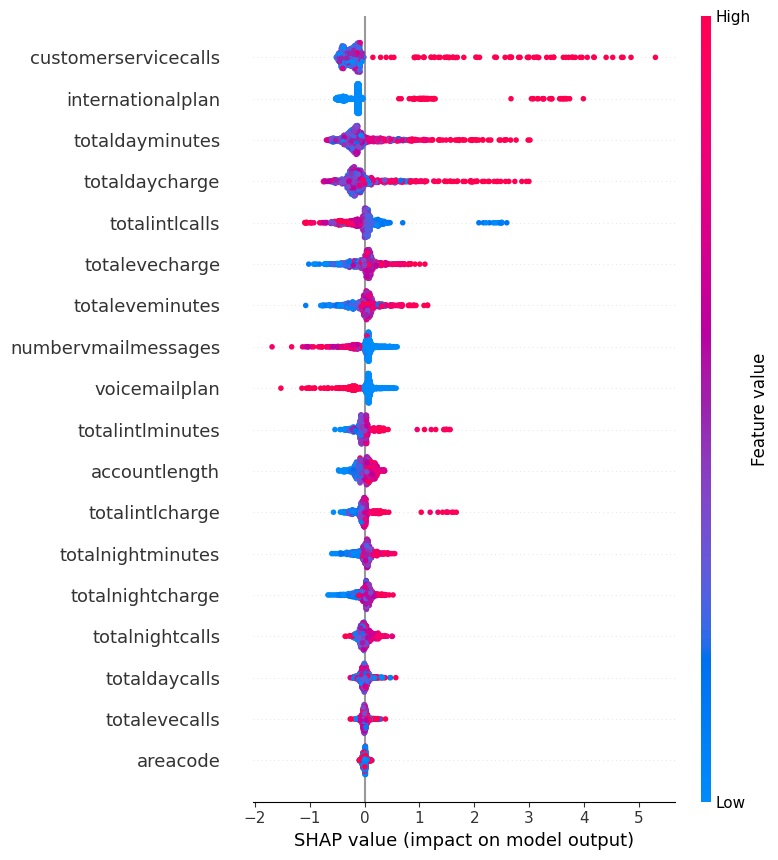

In [ ]:
ex = shap.TreeExplainer(model)
shap_val = ex.shap_values(Xtest)

shap.summary_plot(shap_val, Xtest)

Используем метод LIME для поиска признака дающего наибольший вклад.

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(Xtest.values, feature_names=Xtest.columns.values.tolist(), mode='regression')
explanation = explainer.explain_instance(Xtest.values[2], model.predict, num_features=5)

explanation.show_in_notebook(show_table=True)

## Калибровка вероятностей

Делаем калибровку вероятностей с помощью методов 'sigmoid' и 'isotonic' при помощи CalibratedClassifierCV с `cv=2`.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.naive_bayes import GaussianNB

cb_sigmoid = CalibratedClassifierCV(model, cv=2)
cb_isotonic = CalibratedClassifierCV(model, cv=2, method='isotonic')

cls_models = [
    (cb_sigmoid, 'CatBoost Sigmoid'),
    (cb_isotonic, 'CatBoost Isotonic'),
    (model, 'CatBoost')
]

Рисуем калибровочную кривую для CatBoost и двух кривых после калибровки.

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.6381946	total: 17.4ms	remaining: 3.45s
5:	learn: 0.6308166	total: 20.7ms	remaining: 3.42s
6:	learn: 0.6217580	total: 23.9ms	remaining: 3.39s
7:	learn: 0.6133307	total: 27ms	remaining: 3.35s
8:	learn: 0.6057850	total: 30.2ms	remaining: 3.32s
9:	learn: 0.5968947	total: 33.3ms	remaining: 3.3s
10:	learn: 0.5881552	total: 36.6ms	remaining: 3.29s
11:	learn: 0.5811595	total: 39.7ms	remaining: 3.27s
12:	learn: 0.5738963	total: 43.1ms	remaining: 3.27s
13:	learn: 0.5680179	total: 46.5ms	remaining: 3.27s
14:	learn: 0.5592832	total: 49.8ms	remaining: 3.27s
15:	learn: 0.5527297	total: 52.9ms	remaining: 3.25s
16:	learn: 0.5447090	total: 56.2ms	remaining: 3.25s
17:	learn: 0.5375702	total: 59.6ms	remaining: 3.25s
18:	learn: 0.5326858	total: 61.9ms	remaining: 3.19s
19:	learn: 0.5251375	total: 65ms	remaining: 3.19s
20:	learn: 0.5167540	total: 68.5ms	remaining: 3.19s
21:	learn: 0.5112564	total: 71.6ms	remaining: 3.18s
22:	lea

Text(0.5, 1.0, 'Calibration')

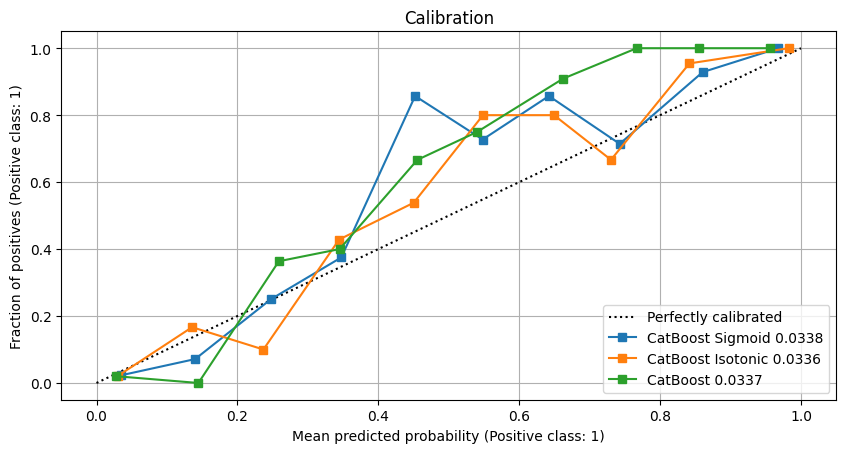

In [ ]:
from sklearn.metrics import brier_score_loss
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4,2)

ax_calibration = fig.add_subplot(gs[:2,:2])
calib_display = {}

for i, (clf, name) in enumerate(cls_models):
    clf.fit(Xtrain, ytrain)
    bs = np.round(brier_score_loss(ytest, clf.predict_proba(Xtest)[:,1]), 4)

    display = CalibrationDisplay.from_estimator(
        clf,
        Xtest,
        ytest,
        n_bins=10,
        name = name+" "+str(bs),
        ax = ax_calibration,
    )
ax_calibration.grid()
ax_calibration.set_title('Calibration')